In [8]:
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import numpy as np 
from statsmodels.stats.weightstats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

In [69]:
df = pd.read_csv('data/tennis.csv')
df.columns

df = df[['year', 'tournament', 'player1 total points won', 'player2 total points won', 'win']]
#df['Pts Difference'] = df['player1 total points won'] - df['player2 total points won']
df = df[['player1 total points won', 'player2 total points won']]
df = df.fillna(0)
#df = sm.add_constant(df)
df


,player1 total points won,player2 total points won
0,41.0,62.0
1,65.0,41.0
2,79.0,69.0
3,60.0,70.0
4,0.0,0.0
...,...,...
1174,130.0,146.0
1175,55.0,31.0
1176,60.0,39.0
1177,92.0,81.0


In [72]:
#p1 = df[df['player1 total points won'] > df['player2 total points won']]['win']

p1 = df['player1 total points won']
p2 = df['player2 total points won']


ttest_ind(p1, p2)

(7.148863982555257, 1.1621829377313556e-12, 2356.0)

In [76]:
result = sm.OLS(p1, p2).fit()
print(result.summary())

                                    OLS Regression Results                                   
Dep. Variable:     player1 total points won   R-squared (uncentered):                   0.969
Model:                                  OLS   Adj. R-squared (uncentered):              0.969
Method:                       Least Squares   F-statistic:                          3.670e+04
Date:                      Wed, 13 Jan 2021   Prob (F-statistic):                        0.00
Time:                              19:31:55   Log-Likelihood:                         -4866.9
No. Observations:                      1179   AIC:                                      9736.
Df Residuals:                          1178   BIC:                                      9741.
Df Model:                                 1                                                  
Covariance Type:                  nonrobust                                                  
                               coef    std err          t   

The result shows that Federer is scoring more points that his opponents because the slope of the linear regression is 1.1242 with a std of 0.006. We can interpret this by saying that for every point made by an opponents, Federer scores 1.1242 on average. Our P-Value is less than 0.05 so our variable is significant. 

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


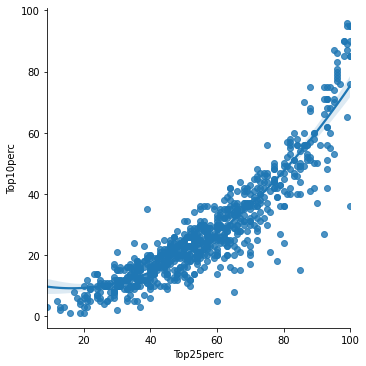

In [5]:
df_college = pd.read_csv('data/college.csv')

df_college.head()

#plot top 10 and top 25 perc. 
sns.lmplot(x='Top25perc', y='Top10perc', data=df_college, order=2)


In [86]:
# 2.2 Do prive schools see more admission overall??
df_college['Private'] = df_college.Private.replace('Yes', 1).replace('No', 0)

x = df_college.Private
y = df_college.Accept

est = sm.OLS(x, y).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                Private   R-squared (uncentered):                   0.123
Model:                            OLS   Adj. R-squared (uncentered):              0.122
Method:                 Least Squares   F-statistic:                              54.67
Date:                Wed, 13 Jan 2021   Prob (F-statistic):                    3.71e-13
Time:                        20:34:31   Log-Likelihood:                         -927.73
No. Observations:                 777   AIC:                                      1857.
Df Residuals:                     776   BIC:                                      1862.
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Accept      9.423e-05   1.27e-05      7.394      0.000    6.93e-05       0.000
==============================================================================
Omnibus:                      149.389   Durbin-Watson:                   0.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.598
Skew:                          -1.301   Prob(JB):                     1.55e-52
Kurtosis:                       3.771   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

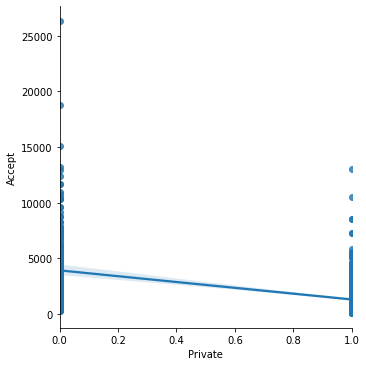

In [88]:
sns.lmplot(x="Private", y="Accept", data=df_college, order=1)

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

In [11]:
names = ['mpg','cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df_auto = pd.read_csv('data/auto.csv', skiprows=[0,1], delim_whitespace=True, names = names)
df_auto.horsepower = df_auto.horsepower.replace('?', np.nan).astype('float')
df_auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
394,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
395,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


In [12]:
sub_df = df_auto[['mpg','horsepower']].dropna()
sub_df['horsepower_2'] = sub_df.horsepower ** 2

y = sub_df.mpg
x = sub_df.drop(columns=['mpg'])

est = sm.OLS(y, x).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.889
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              1923.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                   1.02e-202
Time:                        09:17:49   Log-Likelihood:                         -1382.5
No. Observations:                 392   AIC:                                      2769.
Df Residuals:                     390   BIC:                                      2777.
Df Model:                           2                                                  
Covariance Type:                  HC2                                                  
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
horsepower       0.4980      0.016     30.448      0.000       0.466       0.530
horsepower_2    -0.0024      0.000    -18.010      0.000      -0.003      -0.002
==============================================================================
Omnibus:                       34.442   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.889
Skew:                           0.801   Prob(JB):                     8.02e-10
Kurtosis:                       3.028   Cond. No.                         440.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

In [ ]:
# is there a relationship between the predictor and the response? 
#By looking at the p value, we can say that there is a relationship between the predictor and the response since the p value < 0.05 

# How strong is the relationship between the predictor and the response?
# With a r-squared = 0.889 and the p < 0.05 we can say there is a strong relantionship between the two. 


# Is the relationship between the predictor and the response positive or negative?
# The horsepower is growing while the mpg is dropping, so there is a negative relation.


In [18]:
# What is the predicted mpg associated with a horsepower of 98?

est.predict([98,1])

array([48.80452067])

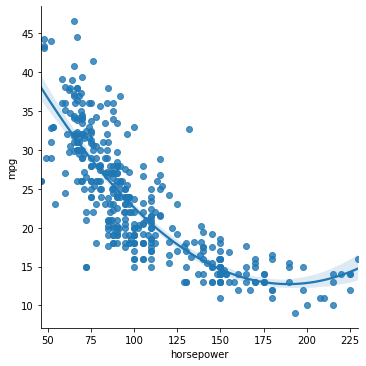

In [20]:

# Make a regression plot the response and the predictor.
sns.lmplot(x="horsepower", y="mpg", data=df_auto, order=2)

# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

In [33]:
df_auto_2 = df_auto.dropna()


y = df_auto_2.mpg 
x = df_auto_2.drop(columns=['mpg', 'name'])
x = sm.add_constant(x)

est = sm.OLS(y, x).fit(cov_type='HC2') #model 
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.5
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          1.98e-139
Time:                        11:00:07   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.697     -3.666      0.000     -26.425      -8.012
cylinders       -0.4934      0.311     -1.586      0.113      -1.103       0.116
displacement     0.0199      0.008      2.401      0.016       0.004       0.036
horsepower      -0.0170      0.014     -1.208      0.227      -0.044       0.011
weight          -0.0065      0.001     -8.304      0.000      -0.008      -0.005
acceleration     0.0806      0.128      0.630      0.529      -0.170       0.331
year             0.7508      0.049     15.196      0.000       0.654       0.848
origin           1.4261      0.275      5.187      0.000       0.887       1.965
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

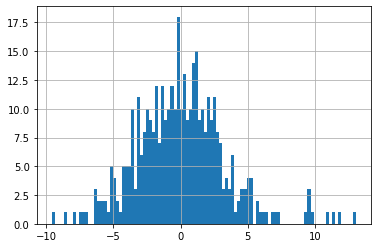

In [42]:
#residual plots to spot outliers

est.resid.hist(bins=100)



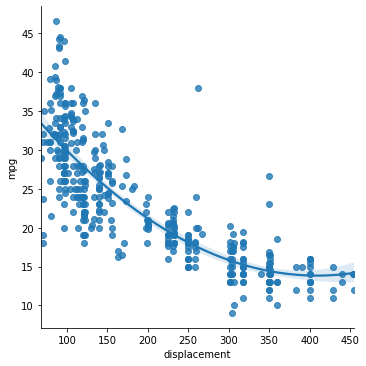

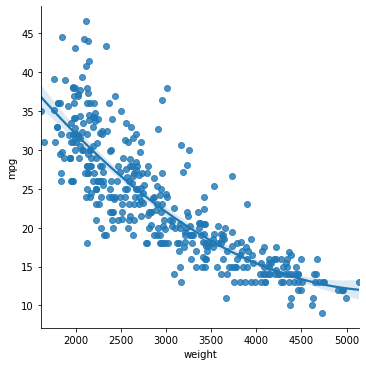

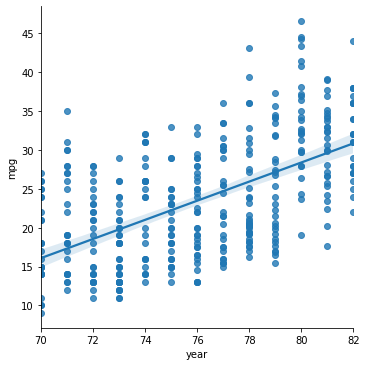

In [56]:
# Residual plot: 
#sns.lmplot(x=df_auto_2.drop(columns=['mpg', 'name']), y=y = df_auto_2.mpg , data=df_auto_2, order=2)


sns.lmplot(x="displacement", y="mpg", data=df_auto_2, order=2)
sns.lmplot(x="weight", y="mpg", data=df_auto_2, order=2)
sns.lmplot(x="year", y="mpg", data=df_auto_2, order=1)


In [58]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#The null hypothesis (H0): Homoscedasticity is present.
# The alternative hypothesis: (Ha): Homoscedasticity is not present (i.e. heteroscedasticity exists)

#Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(est.resid, est.model.exog)

lzip(names, test)


[('Lagrange multiplier statistic', 29.476202401177883),
 ('p-value', 0.0001184324373909795),
 ('f-value', 4.460342346399181),
 ('f p-value', 8.683259637573102e-05)]

1. Is there a relationship between the predictors and the response ? 
Yes there is one, we have the F-stat = 252,4 and the p-value < 0.05. 

2. Which predictors appear to have a statisticallyy significant relationship to the response?
We can see a relationship between : displacemennt and mpg, weight and mpg, year and mpg, and origin and mpg. 

3. What does the coefficcient for the year variable suggest?
The coefficcient for the year variable (0.7508) suggests that with cars made 1 year later, mpg increase by 0.7508 miles per gallons. 

4. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?
The histogram of residual show a normal distribution, which is a good sign. We can see a few outliers around 10 on the x-axis. 

5. Is there heteroscedasticity in the fit?
I would say yes because we obtain a p-value < 0.05 (0.0001184324373909795). With this value we can reject the null hypothesis that homosccedasticity is present. 


# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [74]:
df_car_seats = pd.read_csv('data/carseats.csv')
df_car_seats.head(10)

df_car_seats["dummy_Urban"] = pd.get_dummies(df_car_seats["Urban"], drop_first=True)
df_car_seats["dummy_US"] = pd.get_dummies(df_car_seats["US"], drop_first=True)

x = df_car_seats[['Price', 'dummy_Urban', 'dummy_US']]
y = df_car_seats['Sales']

#add constant
x = sm.add_constant(x)

#model
est = sm.OLS(y,x).fit(cov_type='HC2') 
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     43.09
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           4.04e-24
Time:                        21:44:04   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.0435      0.641     20.333      0.000      11.786      14.301
Price          -0.0545      0.005    -10.515      0.000      -0.065      -0.044
dummy_Urban    -0.0219      0.258     -0.085      0.932      -0.527       0.484
dummy_US        1.2006      0.246      4.878      0.000       0.718       1.683
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [78]:
#4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

x = df_car_seats[['Price', 'dummy_US']]
y = df_car_seats['Sales']

x = sm.add_constant(x)

#model
est = sm.OLS(y,x).fit(cov_type='HC2')

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     64.66
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           4.90e-25
Time:                        21:48:55   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.622     20.944      0.000      11.811      14.250
Price         -0.0545      0.005    -10.543      0.000      -0.065      -0.044
dummy_US       1.1996      0.247      4.863      0.000       0.716       1.683
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

- The price's coefficient is 0.00545, which mean that for each increment of price, sales will drop significantly, =, 

- The urban feature's is -0.0219, which mean that sales in urban are 0.0218 lower than when it's isn`t in an urban area. 

- For US, the sales are up by 1.2006 in the US compare to when it's isnt. 

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

- Urban is not statistically significant, so we fail to reject the null hypothesis.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

- THe R-squared and the F-stat is better in the question #4. 

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

- const  = [11.811, 14.250]
- Price: [-0.065, -0.044]
- US: [0.716, 1.683]